In [2]:
# For gathering data from reddit
import praw # Python Reddit API Wrapper
from praw.models import MoreComments

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import FreqDist
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import re # Remove links
import en_core_web_sm
import spacy

import os
from dotenv import load_dotenv

# for visualization
import seaborn as sns
sns.set(style = 'whitegrid', palette = 'Dark2')
import matplotlib.pyplot as plt
from wordcloud import WordCloud, get_single_color_func
import plotly.express as px


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\avanjavakam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\avanjavakam\AppData\Roaming\nltk_data...


True

In [3]:
# loading development settings for Reddit API
%load_ext dotenv
%dotenv

# Create a reddit connection with reddit API details
reddit = praw.Reddit(client_id = os.getenv("CLIENT_ID"),
                     client_secret = os.getenv("CLIENT_SECRET"),
                     user_agent = os.getenv("USER_AGENT"))
reddit

In [4]:
subreddit = reddit.subreddit('all')
submissions_list = []
search_term = "osprey backpack review"
# search popular subreddits for reviews and get first 3 posts
for submission in subreddit.search(search_term,limit = 20,sort='top'):

    #print(submission.likes)
    #print(submission.num_comments)
    #print(submission.subreddit_subscribers)
    #print(submission.view_count)
    print(submission.upvote_ratio)
    print(submission.score)    
    print(submission.title)
       
    print('Submission ID = ', submission.id, '\n')
    submissions_list.append(submission.id)
submissions_list

0.92
36728
Unpopular opinion, If I can not buy it new now, then it should not be on this sub.
Submission ID =  ixxh3a 

0.79
31877
My experience being a woman of color in the US
Submission ID =  gzq3c9 

0.92
15412
TIFU by asking the admin assistant to spank me in front of HR
Submission ID =  myakb5 

0.96
13763
Cut my salary in half? Kiss your business goodbye.
Submission ID =  lb8evx 

0.94
12808
I spent the last 12 months in a remote wilderness lodge with no internet and cell service, and spent all my time reading. I did a ranking and mini-reviews of the 40ish books I read in that time
Submission ID =  v3cgxz 

0.97
9142
Screw me on my bonus? Make me do two job? Enjoy the backwater you earned.
Submission ID =  rrghuu 

0.98
8572
[Books] The Boyne in the Striped Pajamas: How a bestselling author got into a Twitter slapfight with the Auschwitz Museum and put Legend of Zelda monsters in his serious historical novel because he thought they were real animals
Submission ID =  yhtk49 

0.9

['ixxh3a',
 'gzq3c9',
 'myakb5',
 'lb8evx',
 'v3cgxz',
 'rrghuu',
 'yhtk49',
 'apxgrx',
 '952poe',
 'apy6s3',
 '12eguom',
 'l78cru',
 'idk2ve',
 'femubi',
 '4fvmed',
 'bksnxc',
 'd5ii2y',
 '11cp9nb',
 'lhi5sz',
 'mw2uw1']

In [234]:
# for each submission (post), storing all comments in a list
comments_all = []

fullnames = [f"t3_{id}" for id in submissions_list]

for submission_id in reddit.info(fullnames=fullnames):
    submission_id.comment_sort = 'best'
    post = reddit.submission(id = submission_id)
    post.comment_sort = "best"
    #post
    # each post has comments attribute. 
    # A CommentForest is a list of top-level comments each of which contains a CommentForest of replies.
    # This will have MoreComments objects.
    # These objects represent the “load more comments”, and “continue this thread” links encountered on the website.
    # the CommentForest object has a method called replace_more(), which replaces or removes MoreComments objects from the forest.
    #post.comments.replace_more(limit = None)

    # for comments and replies, use post.comments.list() but be aware that this takes longer as it is computationally intensive
    #for comments in post.comments.list():
    #for only top level comments, use post.comments:
    for comments in post.comments: 
        #print(comments.score)
        comments_all.append(comments.body)
    

#print(comments_all, '\n')
print("total comments scraped = ", len(comments_all))



AttributeError: 'MoreComments' object has no attribute 'body'

In [5]:

#top = subreddit.search(search_term,limit = 20,sort='top').top(params={'t': 'all'}, limit=25) # For a more potentially accurate set of top comments, increase the limit (but it'll take longer)
posts = dict()
all_comments = []
comments_body = []
top_comments_body = {}
    
# search all subreddits and get comments from top posts
for submission in subreddit.search(search_term, limit = 5, sort='relevance'):
    # sort comments by 'best' (which is default mode we see when using reddit)
    submission.comment_sort = 'best'

    # This line is required in case we need commentForest (includes replies tree)
    # or else there would be an error if we do not replace moreComments.
    submission.comments.replace_more(limit = None)

    # exlclude bot posts/advertised posts 
    if not submission.stickied:

        # add original post text to the posts dictionary
        posts[submission.selftext] = submission.score

        # for each post, get top level comments (no replies, no commentForest)
        #if top_level_comments_only:
        real_comments = [comment for comment in list(submission.comments)]
        # for comments and replies (includes commentForest)
        #else:                
            #real_comments = [comment for comment in submission.comments.list()]            
        all_comments += real_comments
# if the search term found any posts on reddit search
if posts:
    # sort all comments by no. of upvotes
    all_comments.sort(key=lambda comment: comment.score, reverse=True)

    # store top n comments with most no. of upvotes
    top_comments = all_comments[:5] #top 5 comments

    for comment in top_comments:
        top_comments_body[comment.body] = comment.score

    for comment in all_comments:
        comments_body.append(comment.body)

    for text, score in posts.items():    
        # add post texts to comments body
        comments_body.append(text)
else:
    print('No posts found! Please enter another search term')
        



't3_12thp00'

In [6]:
# Pre-processing comments

# convert to a string object
# map to a list of strings
strings_all = [str(i) for i in comments_body]
# join all strings spearated by a commma
strings_uncleaned = ' , '.join(strings_all)
strings_uncleaned

# tokenizing and cleaning strings
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|http\S+')
tokenized_string = tokenizer.tokenize(strings_uncleaned)

# converting all tokens to lowercase
tokenized_string_lower = [word.lower() for word in tokenized_string]

# removing stop words
nlp = en_core_web_sm.load()
all_stopwords = nlp.Defaults.stop_words
tokens_without_stopwords = [word for word in tokenized_string_lower if not word in all_stopwords]

# stemming might return a root word that is not an actual word
# whereas, lemmatizing returns a root word that is an actual language word.
# let's normalize words via lemmatizing
lemmatizer = WordNetLemmatizer()

lemmatized_tokens = ([lemmatizer.lemmatize(w) for w in tokens_without_stopwords])
print(lemmatized_tokens)

print("number of words = ", len(lemmatized_tokens))


['additional', 'image', 'http', 'imgur', 'com', 'k0fgakk', 'brand', 'new', 'box', 'removed', 'box', 'photo', 'shipping', 'conus', 'included', 'price', 'm', 'happy', 'ship', 'outside', 'conus', 'shipping', 'paid', 'weight', '44', '8', 'oz', 'personally', 'weighed', 'manufacturer', 'say', '39', '6', 'oz', 'wanting', 'pack', 'size', 'll', 'leap', 'osprey', 'airspeed', 'suspension', 'stumbled', 'airspeed', 'osprey', 'good', '30', 'year', 'ago', 'm', 'airspeed', 'osprey', 'fan', 'people', 'don', 't', 'know', 'construction', 'try', 'cheerlead', 'yk', '2', 'cent', 'need', 'snap', 'pack', 'quick', 'u', 'heihei_the_chicken', 'following', 'flair', '0', 'transaction', 'new', 'seller', 'sure', 'read', 'rule', 'outlined', 'sidebar', 'prior', 'buying', 'selling', 'trading', 'click', 'learn', 'leave', 'feedback', 'confirm', 'trade', 'http', 'www', 'reddit', 'com', 'r', 'geartrade', 'comment', '124vfm8', 'please_read_new_feedback_and_flair_process_online', 'user', 'trade', 'count', 'found', 'user', 'f

In [7]:
# Applying a sentiment analyzer (VADER)
sia = SIA()
results = []

# get polarity score for words
for word in lemmatized_tokens:
    pol_score = sia.polarity_scores(word)
    pol_score['words'] = word
    results.append(pol_score)
results

pd.set_option('display.max_columns', None, 'max_colwidth', None)
df = pd.DataFrame.from_records(results)
df

,neg,neu,pos,compound,words
0,0.0,1.0,0.0,0.0,additional
1,0.0,1.0,0.0,0.0,image
2,0.0,1.0,0.0,0.0,http
3,0.0,1.0,0.0,0.0,imgur
4,0.0,1.0,0.0,0.0,com
...,...,...,...,...,...
216,0.0,1.0,0.0,0.0,sold
217,0.0,0.0,0.0,0.0,u
218,0.0,1.0,0.0,0.0,geartradebot
219,0.0,0.0,0.0,0.0,u


In [8]:
# compound score as seen above is a normalized single unideimensional measure of sentiment for a given word.
# adding a label column
df['label'] = 0 # neutral
df.loc[df['compound'] > 0.10, 'label'] = 1 # positive
df.loc[df['compound'] < -0.10, 'label'] = -1 # negative
df.head()

,neg,neu,pos,compound,words,label
0,0.0,1.0,0.0,0.0,additional,0
1,0.0,1.0,0.0,0.0,image,0
2,0.0,1.0,0.0,0.0,http,0
3,0.0,1.0,0.0,0.0,imgur,0
4,0.0,1.0,0.0,0.0,com,0


In [9]:
# how many words are neutral (0), positive (1) and negative (-1) in sentiment
df.label.value_counts()

0    216
1      5
Name: label, dtype: int64

Most of them are neutral. Comments seem to be neutral - positive skewed.There are only 2 negative words.


In [318]:
# let's look at negative words
df[df['label']== -1]

,neg,neu,pos,compound,words,label


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (2).

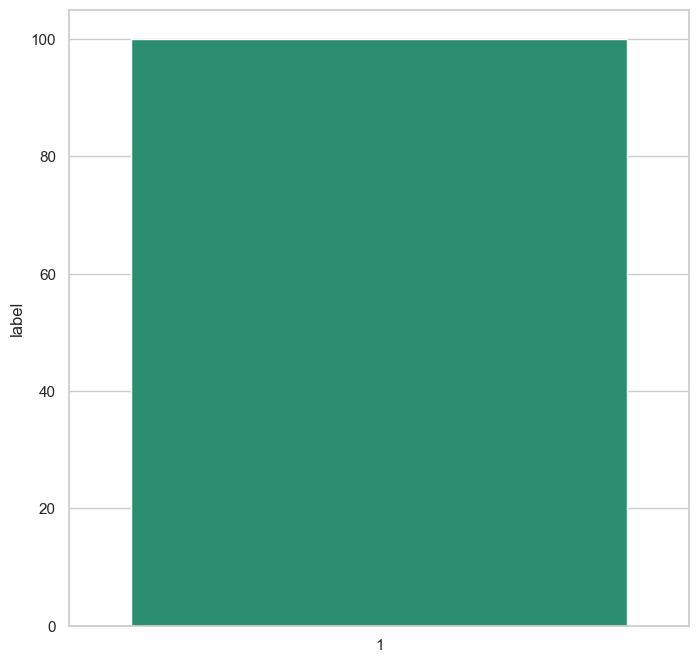

In [15]:
# let's look at how many positive and negative words are found

fig, ax = plt.subplots(figsize = (8,8))

counts = df.loc[df['label'] != 0]['label'].value_counts(normalize=True) * 100

sns.barplot(x = counts.index, y = counts, ax = ax)

ax.set_xticklabels(['Negative', 'Positive'])
ax.set_ylabel("Percentage")
type(fig)

In [17]:
# get percentage of postive and negative words in all the comments 
sentiment_perc_of_words = df.loc[df['label'] != 0]['label'].value_counts(normalize=True) * 100

print(sentiment_perc_of_words)
if sentiment_perc_of_words[1] == 100:
    sentiment_perc_of_words[-1] = 0
if sentiment_perc_of_words[-1] == 100:
    sentiment_perc_of_words[1] = 0

print(sentiment_perc_of_words)

#print(round(sentiment_perc_of_words[1],2))
#print(round(sentiment_perc_of_words[-1],2))


1    100.0
Name: label, dtype: float64
 1    100.0
-1      0.0
Name: label, dtype: float64


In [13]:
# Frequency distribution of the 20 most common positive words
frequent_pos_words = FreqDist(df.loc[df['label'] == 1].words)
frequent_pos_words


FreqDist({'happy': 1, 'good': 1, 'fan': 1, 'cheerlead': 1, 'sure': 1})

In [321]:
sum(frequent_pos_words.values())

5

In [18]:
# Frequency distribution of the 20 most common negative words
frequent_neg_words = FreqDist(df.loc[df['label'] == -1].words)
frequent_neg_words.most_common(20)

[]

In [326]:
color_words_dict = {
    'green': list(df.loc[df['label'] == 1].words),
    'red': list(df.loc[df['label'] == -1].words)
}

# neutral words are grey
default_color = 'grey'
color_words_dict

{'green': ['happy', 'good', 'fan', 'cheerlead', 'sure'], 'red': []}

In [19]:
class SimpleGroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

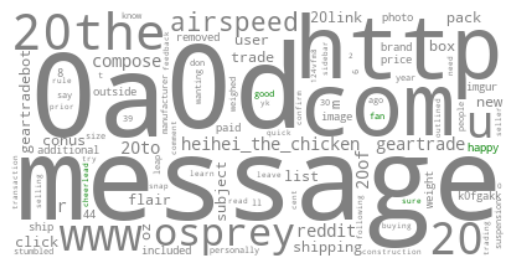

In [325]:
wc = WordCloud(collocations=False, background_color='white').generate_from_frequencies(frequencies=FreqDist(df.words))

grouped_color_func = SimpleGroupedColorFunc(color_words_dict, default_color)
wc.recolor(color_func=grouped_color_func)
plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [22]:
# how many common words to display
no_of_words = 20

# Most common positive words
pos_freq_df = pd.DataFrame(frequent_pos_words.most_common(no_of_words))
pos_freq_df = pos_freq_df.rename(columns = {0: "Bar Graph of Frequent Positive Words", 1: "Count"}, inplace=False)

fig = px.bar(pos_freq_df, x = "Bar Graph of Frequent Positive Words", y = "Count", title = "Commonly Used Positive Words Count")

fig.show()
type(fig)

plotly.graph_objs._figure.Figure

In [21]:
# Most common negative words

neg_freq_df = pd.DataFrame(frequent_neg_words.most_common(no_of_words))
len(neg_freq_df)


#neg_freq_df = neg_freq_df.rename(columns = {0: "Bar Graph of Frequent Negative Words", 1: "Count"}, inplace=False)

#fig = px.bar(neg_freq_df, x = "Bar Graph of Frequent Negative Words", y = "Count", title = "Commonly Used Negative Words Count")

#fig.show()

0

Ideas for improvement:

Try sentiment for sentences instead of words. There may be some sentences such a "They try to take away my uncertainity and nervousness" which is obviously positive but the individual words "uncertainity" and "nervousness" contribute more to negative score.

Replies are not taken into consideration and only top-level comments are analyzed. Looping through multiple posts and comments and their nested replies is computationally expensive. So, I decided to trade off information in replies for faster extraction of only top-level comments across posts. This approach proved to be faster and accurate enough to get the overall product/platform/service sentiment rather than wait longer to get the results.

References:
- https://www.learndatasci.com/tutorials/predicting-reddit-news-sentiment-naive-bayes-text-classifiers/
- https://www.nltk.org/
- https://praw.readthedocs.io/en/latest/tutorials/comments.html#extracting-comments-with-praw
- https://stackoverflow.com/questions/61919884/mapping-wordcloud-color-to-a-value-for-sentiment-analysis
- https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/
- https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
- https://docs.streamlit.io/

